In [19]:
import pandas as pd

# Load datasets
agents = pd.read_excel("/Users/snatzehua/Downloads/nus_agent_info_df.xlsx")
policies = pd.read_excel("/Users/snatzehua/Downloads/nus_policy_info_df.xlsx")
clients = pd.read_excel("/Users/snatzehua/Downloads/nus_client_info_df.xlsx")

# Show all columns
pd.set_option('display.max_columns', None)  

In [20]:
merged_df = pd.merge(policies, agents, on="agntnum", how="left")
merged_df = pd.merge(merged_df, clients, on="secuityno", how="left")

merged_df.head()

,chdrnum,agntnum,secuityno,occdate,annual_premium,product,flg_main,flg_rider,flg_inforce,flg_lapsed,flg_cancel,flg_expire,flg_converted,product_grp,cust_age_at_purchase_grp,cust_tenure_at_purchase_grp,agent_age,agent_gender,agent_marital,agent_tenure,cnt_converted,annual_premium_cnvrt,pct_lapsed,pct_cancel,pct_inforce,pct_prod_0_cnvrt,pct_prod_1_cnvrt,pct_prod_2_cnvrt,pct_prod_3_cnvrt,pct_prod_4_cnvrt,pct_prod_5_cnvrt,pct_prod_6_cnvrt,pct_prod_7_cnvrt,pct_prod_8_cnvrt,pct_prod_9_cnvrt,pct_SX0_unknown,pct_SX1_male,pct_SX2_female,pct_AG01_lt20,pct_AG02_20to24,pct_AG03_25to29,pct_AG04_30to34,pct_AG05_35to39,pct_AG06_40to44,pct_AG07_45to49,pct_AG08_50to54,pct_AG09_55to59,pct_AG10_60up,cluster,agent_product_expertise,cltsex,cltdob,marryd,race_desc_map,cltpcode,household_size,economic_status,family_size,household_size_grp,family_size_grp
0,PID:281,AIN:62,CIN:6957,2018-11-12,0.0,prod_8,1,0,1,0,0,0,1,PG:0,AG05_35to39,TNR2_lt1yr,31.0,M,S,6,47,6112.000,0.1,0.243689,0.936170,0.0,0.212766,0.319149,0.0,0.000000,0.000000,0.042553,0.000000,0.425532,0.00000,0.042553,0.531915,0.425532,0.000000,0.000000,0.106383,0.148936,0.297872,0.148936,0.191489,0.000000,0.000000,0.000000,1,['prod_9' 'prod_2' 'prod_0' 'prod_0'],F,1982-03-11,M,Chinese,648146,25.0,78.0,98.0,HH1_lt40,FS5_80up
1,PID:280,AIN:63,CIN:2161,2024-02-22,7.0,prod_8,1,0,1,0,0,0,1,PG:0,AG04_30to34,TNR4_4to8yr,32.0,M,S,71,4560,1045929.756,0.1,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.370175,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,['prod_0' 'prod_9' 'prod_9' 'prod_6' 'prod_0' ...,M,1991-03-18,S,Chinese,680120,57.0,31.0,47.0,HH2_40to80,FS3_40to60
2,PID:2577,AIN:63,CIN:16605,2024-08-28,423.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup,32.0,M,S,71,4560,1045929.756,0.1,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.370175,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,['prod_0' 'prod_9' 'prod_9' 'prod_6' 'prod_0' ...,M,1973-04-16,M,Chinese,640818,56.0,30.0,60.0,HH2_40to80,FS4_60to80
3,PID:2578,AIN:63,CIN:16605,2024-08-27,217.0,prod_6,1,0,1,0,0,0,1,PG:0,AG08_50to54,TNR5_8yrup,32.0,M,S,71,4560,1045929.756,0.1,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.370175,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,['prod_0' 'prod_9' 'prod_9' 'prod_6' 'prod_0' ...,M,1973-04-16,M,Chinese,640818,56.0,30.0,60.0,HH2_40to80,FS4_60to80
4,PID:305,AIN:63,CIN:7917,2024-08-28,432.0,prod_6,1,0,1,0,0,0,1,PG:0,AG07_45to49,TNR4_4to8yr,32.0,M,S,71,4560,1045929.756,0.1,0.157312,0.854605,0.0,0.041009,0.051974,0.0,0.010307,0.033333,0.063596,0.007237,0.761404,0.03114,0.024561,0.605263,0.370175,0.009649,0.022149,0.050439,0.260307,0.212719,0.181360,0.121711,0.071711,0.019956,0.011842,1,['prod_0' 'prod_9' 'prod_9' 'prod_6' 'prod_0' ...,F,1978-06-20,M,Malay,760401,23.0,0.0,55.0,HH1_lt40,FS3_40to60


In [21]:
# Map age groups to number
age_mapping = {
    "AG01_lt20": 17, "AG02_20to24": 22, "AG03_25to29": 27, "AG04_30to34": 32,
    "AG05_35to39": 37, "AG06_40to44": 42, "AG07_45to49": 47, "AG08_50to54": 52,
    "AG09_55to59": 57, "AG10_60up": 62
}
merged_df["cltage"] = merged_df["cust_age_at_purchase_grp"].map(age_mapping)

# Add median to all missing values if possible
columns_to_fix = ["agent_age", "household_size", "economic_status", "family_size", "cltage"]
median_values = {col: merged_df[col].median() for col in columns_to_fix}
merged_df.fillna(median_values, inplace=True)

# Map gender to numerical values
cltsex_map = {"M": 1, "F": 0, " ": 0.5}
agent_gender_map = {"M": 1, "F": 0, "U": 0.5}
merged_df["cltsex"] = merged_df["cltsex"].map(cltsex_map).fillna(0.5)
merged_df["agent_gender"] = merged_df["agent_gender"].map(cltsex_map).fillna(0.5)

# Drop rows where key fields have NaNs (cannot be filled)
merged_df.dropna(subset=["cltdob", "cltpcode"], inplace=True)

In [22]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# X Variables
X_continuous_vars = ["cltsex", "cltage", "household_size", "economic_status", "family_size"]
X_categorical_vars = ["product", "product_grp", "race_desc_map"]
X_percentage_vars = []

# Define the target variable
target_var = "agntnum"

# Drop columns not in the above lists
X_all_vars = X_continuous_vars + X_categorical_vars + X_percentage_vars
all_vars = X_all_vars + [target_var]
df = merged_df.drop(columns=[col for col in merged_df.columns if col not in all_vars])

### --- Step 1: Keep Percentage Variables Unchanged ---
X_percentage = df[X_percentage_vars] if X_percentage_vars else pd.DataFrame(index=df.index)

### --- Step 2: Apply Min-Max Scaling (0-1) to Continuous Variables ---
X_scaler = MinMaxScaler()
X_continuous = pd.DataFrame(X_scaler.fit_transform(df[X_continuous_vars]), 
                            columns=X_continuous_vars, 
                            index=df.index)

### --- Step 3: Label Encoding for Categorical Variables ---
label_encoders = {}
for col in X_categorical_vars:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical to numerical labels
    label_encoders[col] = le  # Store encoders for future use

X_categorical = df[X_categorical_vars]

### --- Step 4: Combine All Processed Features ---
X_final = pd.concat([X_continuous, X_percentage, X_categorical], axis=1)

### --- Step 5: Encode Target Variable (agntnum) for Classification ---
label_encoder = LabelEncoder()
Y_final = label_encoder.fit_transform(df[target_var])  # Convert categorical labels to integers

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_final.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y_final, dtype=torch.long)  # Classification targets should be long

# Print final tensor shapes
print("X Tensor Shape:", X_tensor.shape)
print("Y Tensor Shape:", Y_tensor.shape)
print("Unique Classes in Y:", len(np.unique(Y_final)))  # Debugging: Check class distribution


X Tensor Shape: torch.Size([29263, 8])
Y Tensor Shape: torch.Size([29263])
Unique Classes in Y: 10018


In [23]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Define X labels
X_numerical_cols = ["cltage", "cltsex", "agent_age", "household_size", "economic_status", "family_size"]

# Define Y labels
Y = ["agntnum"]

Epoch [1/100], Avg Loss: 9.2310, Top-1 Accuracy: 0.14%, Top-3 Accuracy: 0.44%, Top-5 Accuracy: 0.72%
Epoch [2/100], Avg Loss: 8.4925, Top-1 Accuracy: 0.07%, Top-3 Accuracy: 0.26%, Top-5 Accuracy: 0.53%
Epoch [3/100], Avg Loss: 7.7718, Top-1 Accuracy: 0.22%, Top-3 Accuracy: 0.58%, Top-5 Accuracy: 0.92%
Epoch [4/100], Avg Loss: 7.1966, Top-1 Accuracy: 0.44%, Top-3 Accuracy: 0.91%, Top-5 Accuracy: 1.37%
Epoch [5/100], Avg Loss: 6.7018, Top-1 Accuracy: 0.51%, Top-3 Accuracy: 1.47%, Top-5 Accuracy: 2.22%
Epoch [6/100], Avg Loss: 6.2504, Top-1 Accuracy: 0.63%, Top-3 Accuracy: 1.78%, Top-5 Accuracy: 2.87%
Epoch [7/100], Avg Loss: 5.8657, Top-1 Accuracy: 1.01%, Top-3 Accuracy: 2.02%, Top-5 Accuracy: 3.11%
Epoch [8/100], Avg Loss: 5.5417, Top-1 Accuracy: 1.06%, Top-3 Accuracy: 2.75%, Top-5 Accuracy: 3.79%
Epoch [9/100], Avg Loss: 5.2871, Top-1 Accuracy: 1.38%, Top-3 Accuracy: 3.19%, Top-5 Accuracy: 4.41%
Epoch [10/100], Avg Loss: 5.0778, Top-1 Accuracy: 1.64%, Top-3 Accuracy: 3.64%, Top-5 Accur

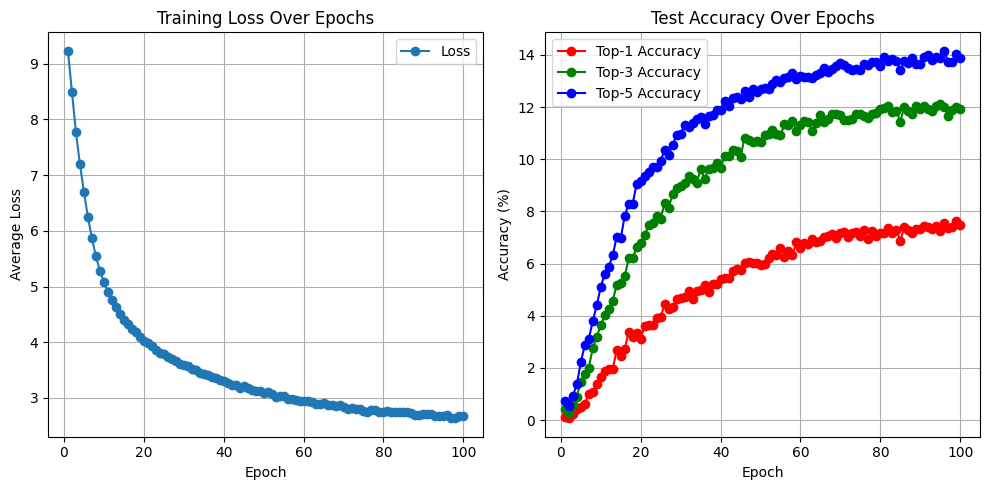

Model training complete and saved!


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(42)

# Convert DataFrame to PyTorch Tensors
X_tensor = torch.tensor(X_final.values, dtype=torch.float32)
Y_tensor = torch.tensor(df['agntnum'].astype('category').cat.codes.values, dtype=torch.long)

# Move tensors to the chosen device (CPU/GPU)
X_tensor, Y_tensor = X_tensor.to(device), Y_tensor.to(device)

# Split into Train and Test Sets
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor, Y_tensor), [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Neural Network Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()

        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()

        self.fc4 = nn.Linear(32, output_size)  # No activation for logits
        
    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize Model
input_size = X_final.shape[1]
output_size = len(df['agntnum'].astype('category').cat.categories)
model = NeuralNetwork(input_size, output_size).to(device)

# Apply Xavier Initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(initialize_weights)

# Compute Class Weights for Imbalanced Dataset
class_counts = df['agntnum'].value_counts().sort_index().values
class_weights = torch.tensor(1.0 / (class_counts / class_counts.sum()), dtype=torch.float32).to(device)

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # Class weights
        self.gamma = gamma  # Focus parameter

    def forward(self, logits, targets):
        ce_loss = nn.CrossEntropyLoss(weight=self.alpha)(logits, targets)
        pt = torch.exp(-ce_loss)  # Compute pt
        focal_loss = (1 - pt) ** self.gamma * ce_loss  # Apply focal factor
        return focal_loss.mean()

# Define Loss Function with Class Weights
loss_function = FocalLoss(alpha=class_weights.to(device))

# Define Optimizer with Lower Learning Rate
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

# Training Loop
loss_history = []
top1_accuracy_history = []
top3_accuracy_history = []
top5_accuracy_history = []
epochs = 200
best_loss = float('inf')
patience = 10
counter = 0

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to device

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    # Evaluate Model on Test Set after Each Epoch (Top-1, Top-3, and Top-5 Accuracy)
    model.eval()
    correct_top1 = 0
    correct_top3 = 0
    correct_top5 = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # Move batch to device
            outputs = model(batch_X)

            # Top-1 Accuracy
            _, predicted_top1 = torch.max(outputs, 1)
            correct_top1 += (predicted_top1 == batch_y).sum().item()

            # Top-3 Accuracy
            top3_preds = torch.topk(outputs, 3, dim=1).indices  # Get top 3 predictions
            correct_top3 += sum(batch_y[i] in top3_preds[i] for i in range(len(batch_y)))

            # Top-5 Accuracy
            top5_preds = torch.topk(outputs, 5, dim=1).indices  # Get top 5 predictions
            correct_top5 += sum(batch_y[i] in top5_preds[i] for i in range(len(batch_y)))

            total += batch_y.size(0)

    top1_accuracy = 100 * correct_top1 / total
    top3_accuracy = 100 * correct_top3 / total
    top5_accuracy = 100 * correct_top5 / total
    top1_accuracy_history.append(top1_accuracy)
    top3_accuracy_history.append(top3_accuracy)
    top5_accuracy_history.append(top5_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_loss:.4f}, Top-1 Accuracy: {top1_accuracy:.2f}%, Top-3 Accuracy: {top3_accuracy:.2f}%, Top-5 Accuracy: {top5_accuracy:.2f}%")

    # Early Stopping Check
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break
    
    # Adjust learning rate based on loss
    scheduler.step()

# Final Evaluation on Test Set
print(f"Final Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Final Top-3 Accuracy: {top3_accuracy:.2f}%")
print(f"Final Top-5 Accuracy: {top5_accuracy:.2f}%")

# Plot Accuracy Curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(range(1, len(top1_accuracy_history) + 1), top1_accuracy_history, marker='o', label="Top-1 Accuracy", color='r')
plt.plot(range(1, len(top3_accuracy_history) + 1), top3_accuracy_history, marker='o', label="Top-3 Accuracy", color='g')
plt.plot(range(1, len(top5_accuracy_history) + 1), top5_accuracy_history, marker='o', label="Top-5 Accuracy", color='b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Save Model
torch.save(model.state_dict(), 'neural_network.pth')
print("Model training complete and saved!")
